In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load libraries
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

In [2]:
#Loading Data
df= pd.read_csv("../data/german_credit_data.csv")
df.head()

,Age,Sex,Job,Housing,SavingAccounts,CheckingAccount,CreditAmount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
features= df.loc[:, df.columns != 'Risk']
categorical_cols= features.select_dtypes(include='O').columns.tolist()
print(categorical_cols)

['Sex', 'Housing', 'SavingAccounts', 'CheckingAccount', 'Purpose']


In [ ]:
#Data preprocessing
df= df.copy()

#Missing values
df['SavingAccounts']= df['SavingAccounts'].fillna('unknown')
df['CheckingAccount']= df['CheckingAccount'].fillna('unknown')

#Encoding categorical variables
label_encoders= {}
for col in categorical_cols:
    le= LabelEncoder()
    df[col]= le.fit_transform(df[col])
    label_encoders[col]= le

df.head()

,Age,Sex,Job,Housing,SavingAccounts,CheckingAccount,CreditAmount,Duration,Purpose,Risk
0,67,1,2,1,4,0,1169,6,5,good
1,22,0,2,1,0,1,5951,48,5,bad
2,49,1,1,1,0,3,2096,12,3,good
3,45,1,2,0,0,0,7882,42,4,good
4,53,1,2,0,0,0,4870,24,1,bad


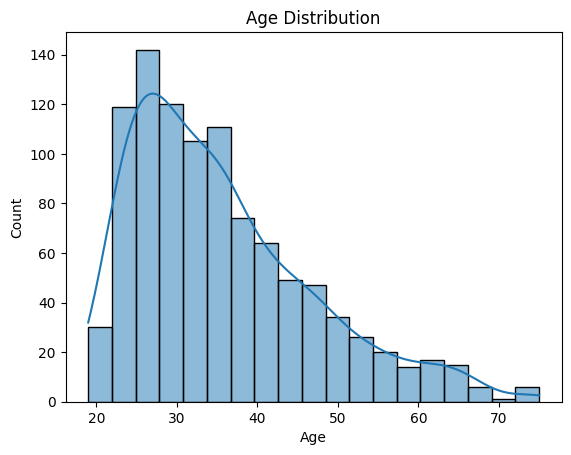

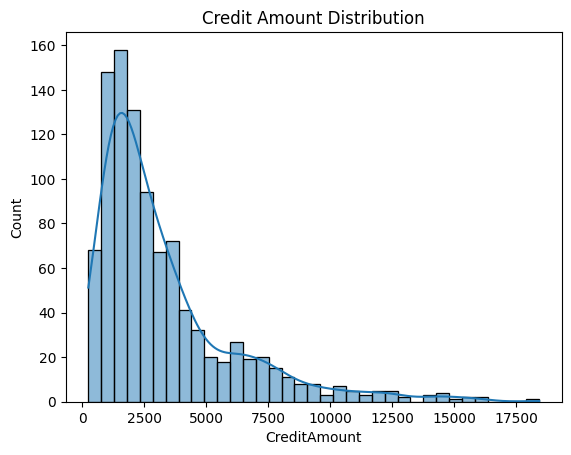

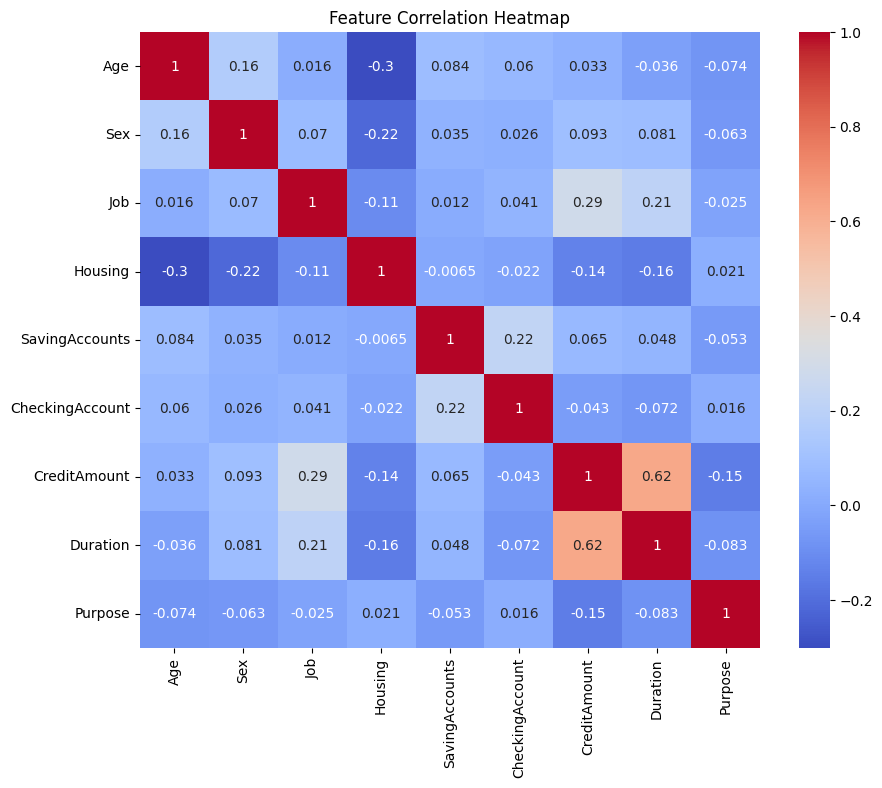

In [5]:
#EDA

#Convert infinite values to nan before analysis
df= df.replace([np.inf, -np.inf], np.nan)

# Age distribution
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

# Credit amount distribution
sns.histplot(df['CreditAmount'], kde=True)
plt.title('Credit Amount Distribution')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(exclude='O').corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [7]:
#Splitting data to train-test split
import warnings
warnings.filterwarnings('ignore')
df['Risk']= df['Risk'].replace({'good': 1, 'bad': 0}) 
X= df.drop(columns=['Risk'])
y= df['Risk']

print(X.shape)
print(y.shape)

(1000, 9)
(1000,)


In [8]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize features
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)

In [9]:
#Feature Selection based on statistical tests
from sklearn.feature_selection import SelectKBest, chi2
best_features= SelectKBest(score_func=chi2, k=5)
fit= best_features.fit(X, y)
df_scores= pd.DataFrame(fit.scores_)
df_columns= pd.DataFrame(X.columns)

feature_scores= pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns= ['Specs', 'Score']
print(feature_scores.nlargest(10, 'Score'))

             Specs         Score
6     CreditAmount  58262.490007
7         Duration    321.030795
5  CheckingAccount    123.333665
4   SavingAccounts     72.269985
0              Age     30.200309
8          Purpose      5.078196
1              Sex      1.766736
2              Job      0.240196
3          Housing      0.098217


In [10]:
#Test Options and Evaluation metrics
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))

In [11]:
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [12]:
#KFold cross validation
import warnings
warnings.filterwarnings('ignore')
results= []
names= []
for name, model in models:
    kfold= KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results= cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    message= f"{name}: {cv_results.mean()}, {cv_results.std()}"
    print(message)

LR: 0.725, 0.03307189138830739
LDA: 0.72375, 0.03599045012221993
KNN: 0.705, 0.05367727638395971
CART: 0.6675, 0.04616546328154846
NB: 0.72875, 0.027414640249326636
SVM: 0.73375, 0.048428426569526284
NN: 0.72, 0.03363406011768427
AB: 0.7, 0.043301270189221926
GBM: 0.7112499999999999, 0.056857827077720795
RF: 0.74125, 0.04403478738452135
ET: 0.71625, 0.05063657275132274


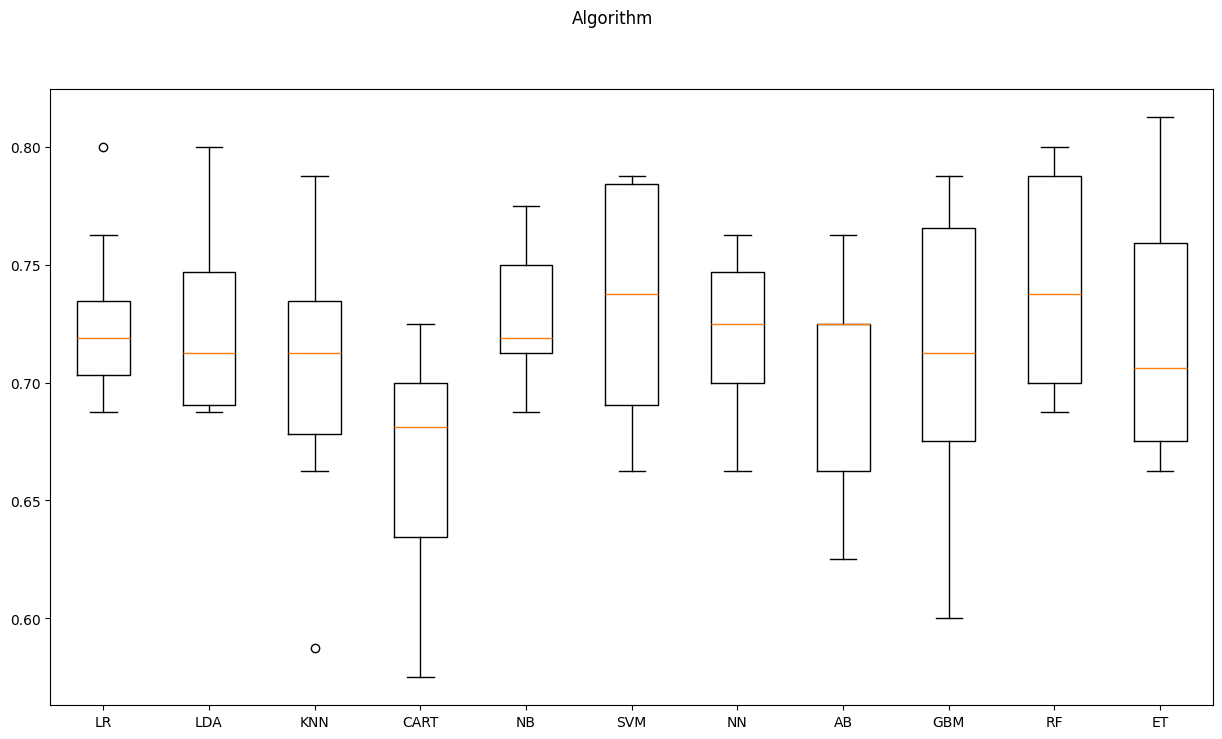

In [13]:
fig= plt.figure()
fig.suptitle('Algorithm')
ax= fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.show()

In [ ]:
#Model Tuning and Grid search
#SVM
c_values= [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5]
kernel_values= ['linear', 'poly', 'rbf']
param_grid= dict(C=c_values, kernel=kernel_values)
model= SVC()

kfold= KFold(n_splits=10, random_state=42, shuffle=True)
grid= GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result= grid.fit(X_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means= grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.7350000000000001 using {'C': 1.3, 'kernel': 'rbf'}
#13 0.706250 (0.028641) with: {'C': 0.1, 'kernel': 'linear'}
#12 0.710000 (0.052974) with: {'C': 0.1, 'kernel': 'poly'}
#15 0.698750 (0.060840) with: {'C': 0.1, 'kernel': 'rbf'}
#22 0.696250 (0.025648) with: {'C': 0.3, 'kernel': 'linear'}
#23 0.696250 (0.050327) with: {'C': 0.3, 'kernel': 'poly'}
#24 0.693750 (0.039627) with: {'C': 0.3, 'kernel': 'rbf'}
#16 0.697500 (0.025495) with: {'C': 0.5, 'kernel': 'linear'}
#14 0.706250 (0.044809) with: {'C': 0.5, 'kernel': 'poly'}
#9 0.718750 (0.044459) with: {'C': 0.5, 'kernel': 'rbf'}
#16 0.697500 (0.025495) with: {'C': 0.7, 'kernel': 'linear'}
#11 0.711250 (0.045225) with: {'C': 0.7, 'kernel': 'poly'}
#5 0.728750 (0.036679) with: {'C': 0.7, 'kernel': 'rbf'}
#16 0.697500 (0.025495) with: {'C': 0.9, 'kernel': 'linear'}
#10 0.713750 (0.048878) with: {'C': 0.9, 'kernel': 'poly'}
#4 0.731250 (0.047186) with: {'C': 0.9, 'kernel': 'rbf'}
#16 0.697500 (0.025495) with: {'C': 1.0, 'kernel': 'li

In [15]:
#Finalize model
final_model= SVC(C=1.3, kernel='rbf') 
final_model.fit(X_train, y_train)

,C,1.3
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [16]:
y_pred= final_model.predict(X_test)

In [17]:
#Model evaluation
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.765
0.9645390070921985


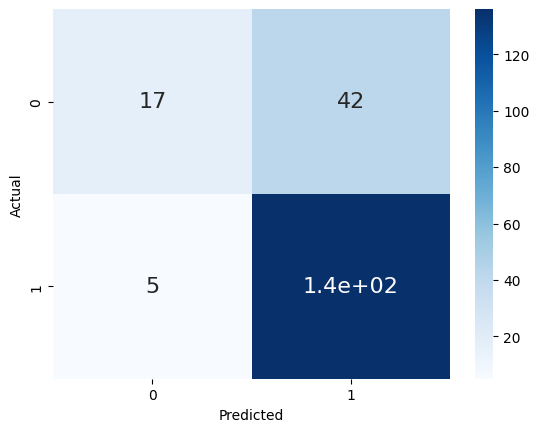

In [18]:
df_cm= pd.DataFrame(confusion_matrix(y_test, y_pred), columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name= 'Actual'
df_cm.columns.name= 'Predicted'
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"size":16});

In [20]:
#Random Forest Classifier
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model_rf = RandomForestClassifier()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid = GridSearchCV(estimator=model_rf, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X_train, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.733750 using {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#4 0.731250 (0.045156) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.728750 (0.041852) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#8 0.711250 (0.045569) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#3 0.732500 (0.048477) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#1 0.733750 (0.041098) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#7 0.726250 (0.044176) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#5 0.730000 (0.042279) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.733750 (0.041852) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [21]:
final_model_rf= RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=20)
final_model_rf.fit(X_train, y_train)

,n_estimators,20
,criterion,'entropy'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
y_pred_rf= final_model_rf.predict(X_test)

In [25]:
print(accuracy_score(y_test, y_pred_rf))
print(recall_score(y_test, y_pred_rf))

0.745
0.950354609929078


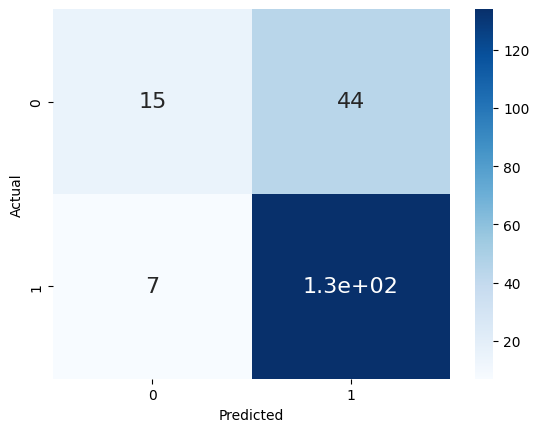

In [26]:
df_cm= pd.DataFrame(confusion_matrix(y_test, y_pred_rf), columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name= 'Actual'
df_cm.columns.name= 'Predicted'
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"size":16});